# Sleep Health and Lifestyle Analysis

This notebook runs the full analysis pipeline using files in `Project-Details/` and the dataset at the project root. It will:

- Verify the environment and required packages
- Inspect `Project-Details/` and dataset files
- Load, clean, and explore the data
- Build simple preprocessing and modeling pipelines
- Export figures and a single `summary.md` for your PowerPoint

Run cells sequentially. The notebook saves outputs to `artifacts/` and `outputs/figures/` (created if missing).

In [1]:
# Section: Environment checks and imports
import sys
import platform
import os
import json
import math
from pathlib import Path

# Data and ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Display settings
%matplotlib inline
sns.set(style='whitegrid')

print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('scikit-learn:', __import__('sklearn').__version__)

# Create artifacts folders
os.makedirs('artifacts', exist_ok=True)
os.makedirs('outputs/figures', exist_ok=True)

# Helper: project root
ROOT = Path('.').resolve()
print('Project root:', ROOT)

Python: 3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.7.1-arm64-arm-64bit-Mach-O
Pandas: 2.3.3
NumPy: 2.3.3
scikit-learn: 1.7.2
Project root: /Users/dustinober/Udacity/Sleep-Health-and-Lifestyle-Analysis


In [2]:
# Section: Inspect Project-Details folder
from pathlib import Path
import mimetypes

proj_details = ROOT / 'Project-Details'

file_rows = []
for p in proj_details.rglob('*'):
    try:
        size = p.stat().st_size
    except Exception:
        size = None
    mime, _ = mimetypes.guess_type(str(p))
    file_rows.append({'path': str(p.relative_to(ROOT)), 'is_dir': p.is_dir(), 'size': size, 'mime': mime})

pd.DataFrame(file_rows).sort_values(['is_dir','path']).head(100)

,path,is_dir,size,mime
2,Project-Details/dataset-overview.md,False,3150,text/markdown
1,Project-Details/presentation-components.md,False,1637,text/markdown
4,Project-Details/project-overview.md,False,1973,text/markdown
3,Project-Details/rubric.md,False,1942,text/markdown
0,Project-Details/tools-and-resources.md,False,1240,text/markdown


In [3]:
# Section: Locate CSVs at repo root and load main dataset
csv_files = list(ROOT.glob('*.csv'))
print('CSV files at repo root:')
for f in csv_files:
    print(' -', f.name)

# Try to locate the target CSV by name
target_name = 'sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv'
if (ROOT / target_name).exists():
    csv_path = ROOT / target_name
elif csv_files:
    csv_path = csv_files[0]
    print('\nUsing first CSV found:', csv_path.name)
else:
    raise FileNotFoundError('No CSV found at project root')

print('\nLoading CSV:', csv_path)
df = pd.read_csv(csv_path)

print('\nShape:', df.shape)
print('\nDtypes:')
print(df.dtypes)

print('\nHead:')
display(df.head())

print('\nMissing values per column:')
print(df.isna().sum().sort_values(ascending=False).head(50))

# Save a small pickle for quick reload
(df.head(100)).to_pickle('artifacts/sample_head.pkl')

CSV files at repo root:
 - sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv

Loading CSV: /Users/dustinober/Udacity/Sleep-Health-and-Lifestyle-Analysis/sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv

Shape: (374, 13)

Dtypes:
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

Head:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea



Missing values per column:
Sleep Disorder             219
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
dtype: int64


Numeric columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


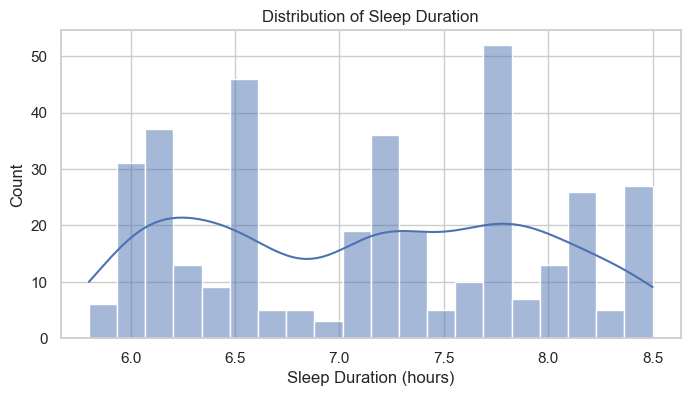

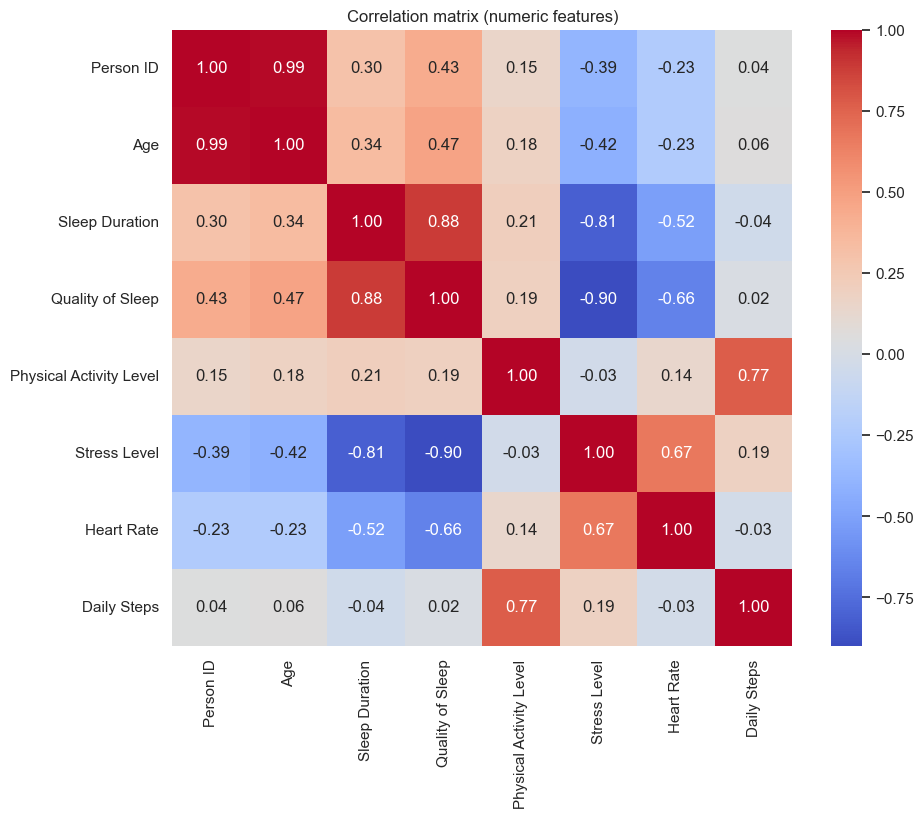

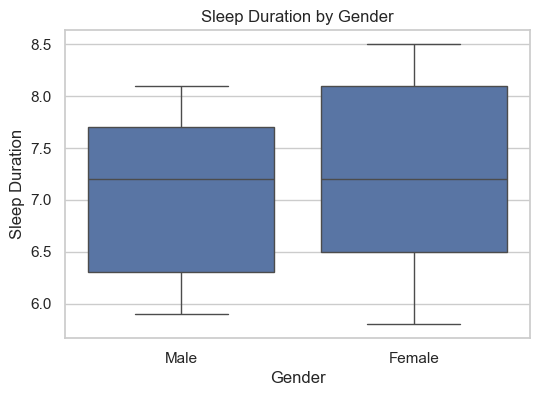

In [6]:
# Section: Basic EDA
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)

# Distribution of target: Sleep Duration
if 'Sleep Duration' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['Sleep Duration'].dropna(), bins=20, kde=True)
    plt.title('Distribution of Sleep Duration')
    plt.xlabel('Sleep Duration (hours)')
    plt.savefig('outputs/figures/sleep_duration_dist.png', dpi=150)
    plt.show()

# Correlation heatmap for numeric columns
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric features)')
plt.savefig('outputs/figures/correlation_matrix.png', dpi=150)
plt.show()

# Boxplot of Sleep Duration by Gender if available
if 'Gender' in df.columns and 'Sleep Duration' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Gender', y='Sleep Duration', data=df)
    plt.title('Sleep Duration by Gender')
    plt.savefig('outputs/figures/sleep_by_gender.png', dpi=150)
    plt.show()

Numeric features used: ['Age', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical features used: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']
Fitting Linear Regression...
Fitting Random Forest...
Metrics saved to artifacts/metrics.json
Models saved to artifacts/models/


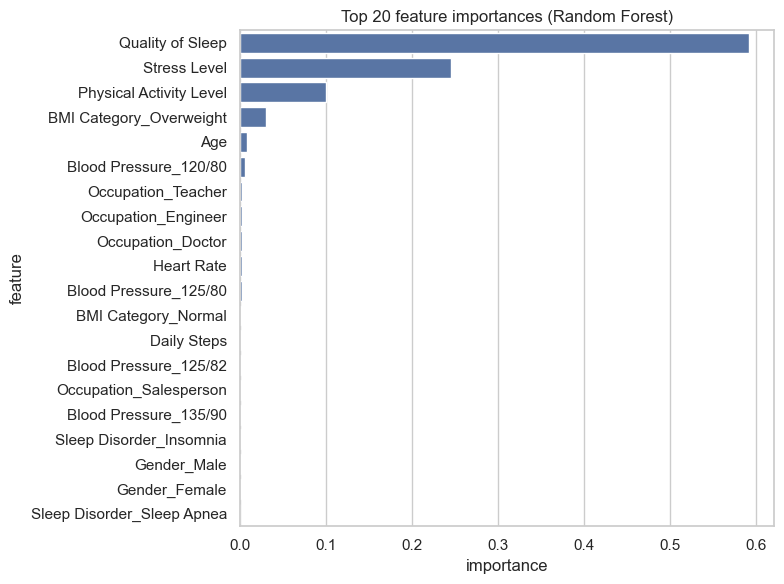

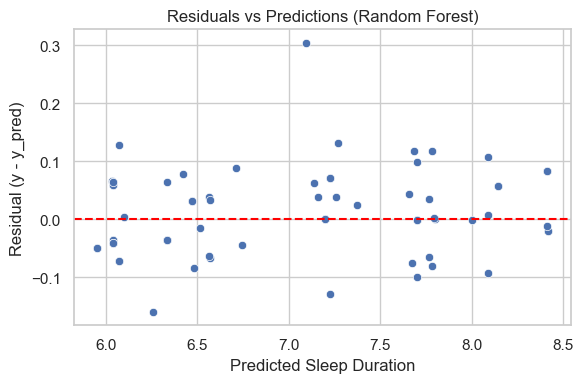

summary.md updated
Done. Artifacts are under artifacts/ and outputs/figures/


In [9]:
# Section: Preprocessing, modeling, evaluation, and artifacts
import joblib
from sklearn.metrics import mean_squared_error, r2_score

# Prepare target and features
TARGET = 'Sleep Duration'
if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found in dataframe")

# Drop rows with missing target
df_model = df.dropna(subset=[TARGET]).copy()

# Define numeric and categorical features automatically
numeric_features = df_model.select_dtypes(include=[np.number]).columns.tolist()
# remove target and identifiers
numeric_features = [c for c in numeric_features if c not in (TARGET, 'Person ID')]
cat_features = df_model.select_dtypes(include=['object','category']).columns.tolist()
cat_features = [c for c in cat_features if c != TARGET]

print('Numeric features used:', numeric_features)
print('Categorical features used:', cat_features)

X = df_model[numeric_features + cat_features]
y = df_model[TARGET]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
], remainder='drop')

# Pipelines
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))])

# Fit models
print('Fitting Linear Regression...')
lr_pipeline.fit(X_train, y_train)
print('Fitting Random Forest...')
rf_pipeline.fit(X_train, y_train)

# Predictions and metrics
preds_lr = lr_pipeline.predict(X_test)
preds_rf = rf_pipeline.predict(X_test)

metrics = {
    'linear_regression': {
        'test_rmse': float(np.sqrt(mean_squared_error(y_test, preds_lr))),
        'test_r2': float(r2_score(y_test, preds_lr))
    },
    'random_forest': {
        'test_rmse': float(np.sqrt(mean_squared_error(y_test, preds_rf))),
        'test_r2': float(r2_score(y_test, preds_rf))
    }
}

# Cross-validated RMSE (neg_mean_squared_error -> take sqrt of -scores)
from sklearn.model_selection import cross_val_score
for name, pipe in [('linear_regression', lr_pipeline), ('random_forest', rf_pipeline)]:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    metrics[name]['cv_rmse_mean'] = float(rmse_scores.mean())
    metrics[name]['cv_rmse_std'] = float(rmse_scores.std())

# Save metrics
os.makedirs('artifacts/models', exist_ok=True)
with open('artifacts/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('Metrics saved to artifacts/metrics.json')

# Save models
joblib.dump(lr_pipeline, 'artifacts/models/linear_regression.pkl')
joblib.dump(rf_pipeline, 'artifacts/models/random_forest.pkl')
print('Models saved to artifacts/models/')

# Feature importances for Random Forest
fitted_preprocessor = rf_pipeline.named_steps['preprocessor']
# construct feature names
num_names = numeric_features
cat_ohe = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot']
try:
    cat_ohe_names = list(cat_ohe.get_feature_names_out(cat_features))
except Exception:
    # fallback name creation
    cat_ohe_names = []
    for c in cat_features:
        vals = X_train[c].astype(str).unique()[:10]
        for v in vals:
            cat_ohe_names.append(f"{c}_{v}")
feature_names = list(num_names) + cat_ohe_names
importances = rf_pipeline.named_steps['regressor'].feature_importances_

fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
fi_df.head(20).to_csv('artifacts/feature_importances_top20.csv', index=False)

# Plot top 20 feature importances
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi_df.head(20))
plt.title('Top 20 feature importances (Random Forest)')
plt.tight_layout()
plt.savefig('outputs/figures/feature_importances_rf_top20.png', dpi=150)
plt.show()

# Residual plot for RF
residuals = y_test - preds_rf
plt.figure(figsize=(6,4))
sns.scatterplot(x=preds_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sleep Duration')
plt.ylabel('Residual (y - y_pred)')
plt.title('Residuals vs Predictions (Random Forest)')
plt.tight_layout()
plt.savefig('outputs/figures/rf_residuals.png', dpi=150)
plt.show()

# Save test predictions
preds_df = pd.DataFrame({'y_true': y_test, 'y_pred_rf': preds_rf, 'y_pred_lr': preds_lr})
preds_df.to_csv('artifacts/test_predictions.csv', index=False)

# Update summary.md programmatically
summary_lines = []
summary_lines.append('# Presentation Summary for Sleep Health and Lifestyle Analysis\n')
summary_lines.append('Project objective: Explore relationships between lifestyle factors and sleep duration; build a baseline predictive model for sleep duration.\n')
summary_lines.append(f'Dataset: {len(df)} rows × {len(df.columns)} columns. Target: `{TARGET}`.\n')
summary_lines.append('Top missingness:\n')
for col, nmiss in df.isna().sum().sort_values(ascending=False).head(10).items():
    summary_lines.append(f'- {col}: {nmiss} missing')
summary_lines.append('\nPreprocessing steps applied:\n')
summary_lines.append('- Numeric imputation (median) + scaling\n- Categorical imputation (most frequent) + one-hot encoding\n')
summary_lines.append('\nModels trained:\n')
for name, m in metrics.items():
    summary_lines.append(f'- {name}: test RMSE={m["test_rmse"]:.3f}, test R2={m["test_r2"]:.3f}, cv RMSE={m["cv_rmse_mean"]:.3f} (±{m["cv_rmse_std"]:.3f})')
summary_lines.append('\nKey figures (files saved under outputs/figures):\n')
summary_lines.append('- sleep_duration_dist.png — distribution of sleep duration\n')
summary_lines.append('- correlation_matrix.png — correlation heatmap of numeric features\n')
summary_lines.append('- sleep_by_gender.png — boxplot of sleep duration by gender\n')
summary_lines.append('- feature_importances_rf_top20.png — top features from Random Forest\n')
summary_lines.append('- rf_residuals.png — residual plot for Random Forest\n')

# Write summary.md (overwrite)
with open('summary.md','w') as f:
    f.write('\n'.join(summary_lines))
print('summary.md updated')

# Save metrics again for visibility
with open('artifacts/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('Done. Artifacts are under artifacts/ and outputs/figures/')